In [ ]:
from torchvision.datasets import CIFAR100
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# 이미지 전처리 및 데이터 증대

In [ ]:
train_data = CIFAR100(root='./data', download=True, train=True, transform=transforms.ToTensor()) # train_trans를 transform에 넣으면 augmentation 진행
test_data = CIFAR100(root='./data', download=True, train=False, transform=transforms.ToTensor()) # test_trans를 transform에 넣으면 augmentation 진행

Files already downloaded and verified
Files already downloaded and verified


23731
(3, 32, 32)
(32, 32, 3)


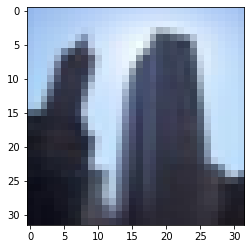

In [ ]:
def imshow(img):
    show_img = img.numpy()
    print(show_img.shape)
    plt.imshow(np.transpose(show_img, (1, 2, 0)))
    print(np.transpose(show_img, (1, 2, 0)).shape)
    plt.show()

rand = np.random.randint(len(train_data))
print(rand)
imshow(train_data[rand][0])

tranforms.Normalize [0.5070 0.4865 0.4409] [0.2673 0.2564 0.2761]

data augmentation

In [ ]:
train_data.data.shape

(50000, 32, 32, 3)

In [ ]:
train_mean = train_data.data.mean(axis=(0,1,2))
train_std = train_data.data.std(axis=(0,1,2))

print(train_mean, train_std)

train_mean = train_mean / 255
train_std = train_std / 255

print(train_mean, train_std)

[129.30416561 124.0699627  112.43405006] [68.1702429  65.39180804 70.41837019]
[0.50707516 0.48654887 0.44091784] [0.26733429 0.25643846 0.27615047]


randomcrop ==>> 이미지를 양쪽에 4픽셀씩 채운 다음 이미지에서 무작위로 32x32로 자름

In [ ]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip()
])

test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])

In [ ]:
train = CIFAR100(root='./data', download=True, train=True, transform=trans)
test = CIFAR100(root='./data', download=True, train=False, transform=test_trans)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 128
train_load = DataLoader(train, batch_size, num_workers=4, shuffle=True)
test_load = DataLoader(test, batch_size, num_workers=4)

# CNN model

output size = ((input_size - kernel_size + 2*padding_size) / strides) + 1

maxpooling ==>> maxpooling 값으로 나눈 값이 output_size

## Resnet

In [ ]:
class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels:int, out_channels:int, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block:BottleNeck, num_block:list, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block:BottleNeck, out_channels, num_blocks:list, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

In [ ]:
def resnet50(): #70
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])


## simple CNN

In [ ]:
# 이미지의 크기가 작기 때문에 적은 합성곱 필터를 적용할 예정이다. 
# MaxPool ==>> 2
# conv ==>> 3
# classifier ==>> 3
# kernel_size => (3, 3), stride => (1, 1), padding(1, 1)을 줬을 경우 output_size => 입력 이미지 원래 사이즈
# MaxPool을 2번 해주기 때문에 합성곱 신경망을 통과하고 나온 이미지의 사이즈 ==>> 8*8
# layer_count = [64, 128, 128, 'M', 128, 256, 256, 'M', 256, 512, 512, 'M', 512] ==>> train 99%, model 20 test 70%, 기존 CNN
layer_count = [64, 128, 'M', 128, 256, 256, 'M' ,512, 512]

In [ ]:
def make_conv2d(layer_count:list, batch_norm=False):
    layers = []
    in_channels = 3

    for i in layer_count:
        if i == 'M':
            layers += [nn.MaxPool2d(2)]
        else:
            layers += [nn.Conv2d(in_channels, i, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(i) ,nn.ReLU()]
            in_channels = i
            
    return nn.Sequential(*layers)

In [ ]:
# 새로운 CNN
class CNN(nn.Module):
    def __init__(self, conv_layer, num_classes = 100):
        super(CNN, self).__init__()
        self.layers = conv_layer
        self.fc1 = nn.Linear(512*8*8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(0.5),
            self.fc2,
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)


    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
# 기존 CNN
class CNN(nn.Module):
    def __init__(self, conv_layer, num_classes = 100):
        super(CNN, self).__init__()
        self.layers = conv_layer
        self.fc = nn.Sequential(
            nn.Linear(512*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )


    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Wide Resnet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)


class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

## 모델 선언

In [ ]:
conv = make_conv2d(layer_count)
model = CNN(conv)

In [ ]:
model

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

## 모델 학습

In [ ]:
# 이전 lr = 0.005
opt = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt,step_size = 20, gamma = 0.8) # 미분값이 0에 가까워질수록 학습률을 줄여주기 위해 사용한다. lr에 감마값을 곱해준다.

In [ ]:
train(model, train_load, opt, scheduler, 100)

epoch : 1	 Loss : 0.034969	 Acc : 2.438
(0.03387265000343323, 3.34)
epoch : 2	 Loss : 0.033498	 Acc : 3.298
(0.032584723520278934, 5.04)
epoch : 3	 Loss : 0.032488	 Acc : 4.252
(0.03163637824058533, 6.67)
epoch : 4	 Loss : 0.031637	 Acc : 5.374
(0.031104162168502807, 8.38)
epoch : 5	 Loss : 0.030700	 Acc : 6.692
(0.02973010458946228, 10.75)
epoch : 6	 Loss : 0.029433	 Acc : 8.806
(0.028134243893623352, 14.33)
epoch : 7	 Loss : 0.027979	 Acc : 11.18
(0.026401351261138916, 16.56)
epoch : 8	 Loss : 0.026407	 Acc : 14.194
(0.024651342988014222, 20.74)
epoch : 9	 Loss : 0.025003	 Acc : 17.184
(0.023186781787872316, 25.31)
epoch : 10	 Loss : 0.023646	 Acc : 20.332
(0.022381568598747254, 26.45)
epoch : 11	 Loss : 0.022363	 Acc : 23.64
(0.02032767057418823, 32.67)
epoch : 12	 Loss : 0.021184	 Acc : 26.308
(0.02048557505607605, 32.91)
epoch : 13	 Loss : 0.020168	 Acc : 28.986
(0.018773107719421388, 37.78)
epoch : 14	 Loss : 0.019161	 Acc : 31.95
(0.017990202379226685, 39.53)
epoch : 15	 Loss : 

# 모델의 학습과 평가를 위한 기타 함수들

In [ ]:
#gpu 사용설정
if torch.cuda.is_available():
    cuda = torch.device('cuda')
else:
    cuda = torch.device('cpu')

print(cuda)

cuda


In [ ]:
def accuracy(pred, label):
    _, predict = torch.max(pred, dim=1)
    print(predict)
    return torch.tensor(torch.sum(predict==label).item()/len(predict))

In [ ]:
def train(model, train_loader, opt, scheduler, epochs):
    
    save_path = '/data/bcw/cifar_models_arg/'
    history = []

    model = model.to(cuda)

    for epoch in range(epochs):
        model.train()

        train_acc = []
        train_loss = []
        lrs = []

        criterion = nn.CrossEntropyLoss().to(cuda)

        for batch, train in enumerate(train_loader):
            data, label = train

            data = data.to(cuda)
            label = label.to(cuda)

            out = model(data)

            loss = criterion(out, label)

            train_loss += [loss.item()]

            pred = out.max(1, keepdim=True)[1]

            acc = pred.eq(label.view_as(pred)).sum().item()

            train_acc += [acc]

            opt.zero_grad()
            loss.backward()
            opt.step()

            #print(f'Batch Size : {batch+1}\t Loss : {loss.item():.6f}\t Acc : {100*(acc / len(data))}')
    
        epoch_loss = sum(train_loss) / len(train_loader.dataset)
        epoch_acc = (100.*sum(train_acc)) / len(train_loader.dataset)
        print(f'epoch : {epoch+1}\t Loss : {epoch_loss:.6f}\t Acc : {epoch_acc}')
        print(evaluate(model, test_load))

        scheduler.step()
        
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), save_path+'model'+str(epoch+1)+'.pth')
        



In [ ]:
def evaluate(model, test_loader):
    model.eval()
    
    criterion = nn.CrossEntropyLoss().to(cuda)
    val_loss = 0
    correct = 0

    for batch_idx, sample in enumerate(test_loader):
        data, label = sample
        data = data.to(cuda)
        label = label.to(cuda)

        output = model(data)
        loss = criterion(output,label)
        val_loss += loss.item()

        prediction = output.max(1, keepdim=True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()

    val_loss /= len(test_loader.dataset)
    val_acc = (100. * correct) / len(test_loader.dataset)


    return val_loss, val_acc

In [ ]:
evaluate(model, test_load)

(0.016821904706954955, 63.98)

In [ ]:
conv = make_conv2d(layer_count)
model = CNN(conv)

In [ ]:
for i in range(20):
    conv = make_conv2d(layer_count)
    model = CNN(conv)
    model.load_state_dict(torch.load("cifar_models/model"+str((i+1)*10)+'.pth'))
    model.to(cuda)
    print(i+1,evaluate(model, test_load))
    

1 (0.025903230500221253, 17.21)
2 (0.01662197403907776, 41.5)
3 (0.012958569872379302, 54.91)
4 (0.011684920001029967, 60.09)
5 (0.011192742109298706, 64.44)
6 (0.011844787383079529, 65.21)
7 (0.012905730533599854, 67.38)
8 (0.013626645052433014, 67.34)
9 (0.014733218157291412, 68.24)
10 (0.015471077477931977, 67.93)
11 (0.016741797745227813, 68.42)
12 (0.01732672674655914, 68.36)
13 (0.017470908224582672, 69.38)
14 (0.01810816696882248, 69.34)
15 (0.018822974240779878, 69.58)
16 (0.019429851138591768, 69.44)
17 (0.019690802991390227, 70.07)
18 (0.020749757874011992, 69.58)
19 (0.021344657588005064, 69.53)
20 (0.021324719059467315, 70.19)


In [ ]:
criterion = nn.CrossEntropyLoss()
for batch, train in enumerate(train_load):
    if batch == 1:
        data, label = train

        data = data
        label = label

        out = model(data)

        loss = criterion(out, label)

        pred = out.max(1, keepdim=True)[1]
        
        print(pred.shape)
        print(label)

        break


torch.Size([128, 1])
tensor([97, 98, 60, 69, 27, 74, 46, 27, 80, 35, 30, 38, 58, 91,  2, 88, 25, 11,
        83, 72, 82, 68, 78,  6, 63, 48, 12, 12,  6, 60, 83, 10, 40, 16, 84, 66,
        77, 67, 77, 17, 43, 67, 88, 45, 12, 50, 98, 90, 16,  6, 60,  8, 25, 27,
        95, 50, 68, 51, 44, 79, 22, 28, 63, 59, 78, 89,  0, 34, 90, 51,  6, 36,
        77, 25, 82, 36, 49, 70, 44, 99, 43, 49, 18, 40, 34, 49, 35,  9, 84, 79,
        23, 69, 35, 35, 18, 53, 23,  6, 59, 95, 52, 25, 86,  5, 56, 61, 23, 93,
        20, 36,  6, 14, 96, 88, 33, 26, 20,  8, 39, 11, 59, 35, 79, 22, 83,  8,
        46, 47])
